In [351]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.decomposition import PCA
from preproc import *
from sklearn.naive_bayes import GaussianNB
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

                        Attribute information
Preg - Pregnancies - Number of times pregnant real [0.0, 17.0]<br />
Plas - Glucose - Plasma glucose concentration in an oral glucose tolerance test real [0.0, 199.0]<br />
Pres - Blood Pressure - Diastolic blood pressure (mm Hg) [0.0, 122.0]<br />
Skin - Skin Thickness - Triceps skin fold thickness (mm) real [0.0, 99.0]<br />
Insu - Insulin - Hour serum insulin (mu U/ml) real [0.0, 846.0]<br />
Mass - BMI Body mass index (weight in kg/(height in m)^2) [0.0, 67.1]<br />
Pedi - Diabetes Pedigree Function Diabetes pedigree function real [0.078, 2.42]
Age -  years real [21.0, 81.0]<br />
Outcome - diabetes or not

In [352]:
header = ['Preg', 'Plas', 'Pres','Skin', 'Insu', 'Mass', 'Pedi', 'Age', 'Outcome']
df = pd.read_csv('pima.csv', names=header)

In [353]:
# all data to float,  0 to NaN in relevant columns
df.drop(df.index[0], inplace=True)
df = df.astype(float)
df.iloc[:, 1:-3].replace(0,np.nan,inplace=True)
fill_n(df)
df.describe()

/home/usenko_maxym/.local/lib/python3.5/site-packages/pandas/core/frame.py:4032: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


,Preg,Plas,Pres,Skin,Insu,Mass,Pedi,Age,Outcome
count,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0
mean,3.8,121.7,72.4,29.2,155.5,32.5,0.5,33.2,0.3
std,3.4,30.4,12.1,8.8,85.0,6.9,0.3,11.8,0.5
min,0.0,44.0,24.0,7.0,14.0,18.2,0.1,21.0,0.0
25%,1.0,99.8,64.0,25.0,121.5,27.5,0.2,24.0,0.0
50%,3.0,117.0,72.2,29.2,155.5,32.4,0.4,29.0,0.0
75%,6.0,140.2,80.0,32.0,155.5,36.6,0.6,41.0,1.0
max,17.0,199.0,122.0,99.0,846.0,67.1,2.4,81.0,1.0


In [354]:
# number of Nans in every column
nans = [{i:df[i].isna().sum()} for i in df.columns]
nans

[{'Preg': 0},
 {'Plas': 0},
 {'Pres': 0},
 {'Skin': 0},
 {'Insu': 0},
 {'Mass': 0},
 {'Pedi': 0},
 {'Age': 0},
 {'Outcome': 0}]

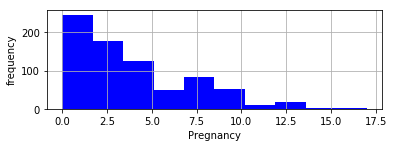

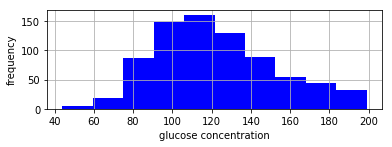

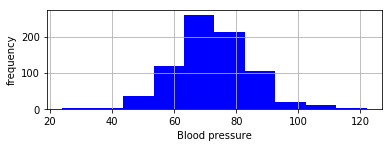

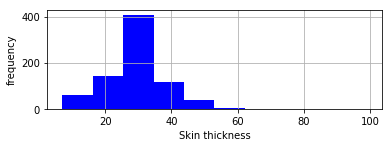

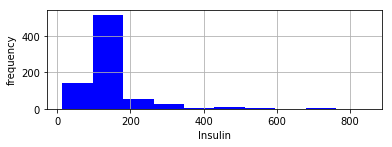

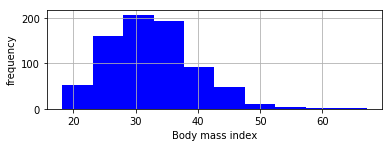

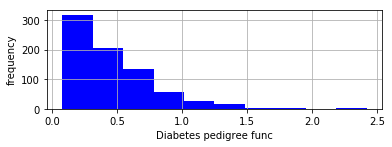

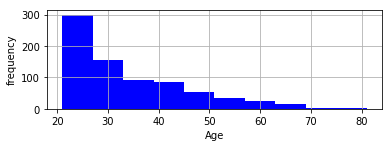

In [355]:
# histograms are useful to show distribution of columns
n = {'Preg': 'Pregnancy', 'Plas': 'glucose concentration', 'Pres': 'Blood pressure', 'Skin': 'Skin thickness',
    'Insu': 'Insulin', 'Mass': 'Body mass index', 'Pedi': 'Diabetes pedigree func', 'Age': 'Age'}
for col in df.columns[:-1]:
    fig = plt.figure()
    ax = plt.subplot(211)
    ax.set_xlabel(n[col])
    ax.set_ylabel('frequency')
    df[col].hist(color = 'blue')

##### We can see that distributions of age, diabetes pedigree and pregrancy are similar in form. Also distributions of BMI, skin thickness and blood pressure have some similarity. So lets plot stacked histogram for them.

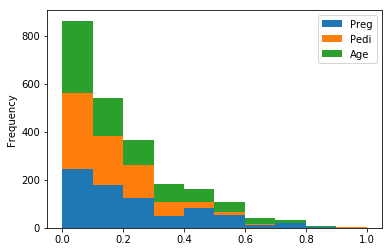

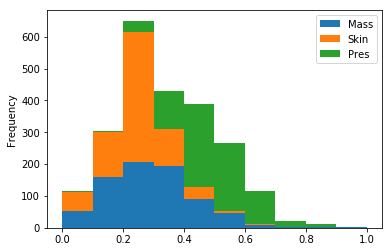

In [356]:
# scaling and stacked histograms
df1 = df.copy()
scaling(df)
df[['Preg', 'Pedi', 'Age']].plot.hist(stacked=True)
df[['Mass', 'Skin', 'Pres']].plot.hist(stacked=True)

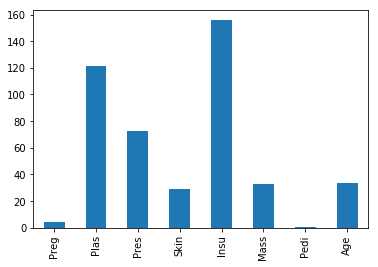

In [357]:
# barplot for the means of different column to show difference between absolute values
means = df1.iloc[:, :-1].mean(axis=0, skipna=True)
means.plot(kind = 'bar')


##### Absolute values of Preg and Pedi are very small comparing to others. 

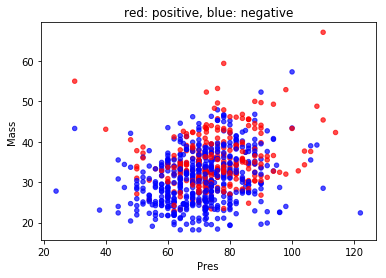

In [358]:
# scatter are useful for showing impurity of classes
label_color = ['red' if i == 1 else 'blue' for i in df1['Outcome']]
df1.plot.scatter(x='Pres', y='Mass', marker='o',
        alpha=0.7, # opacity
        color=label_color,
        title="red: positive, blue: negative" )

##### People with low mass and blood pressure are more likely to be healthy.

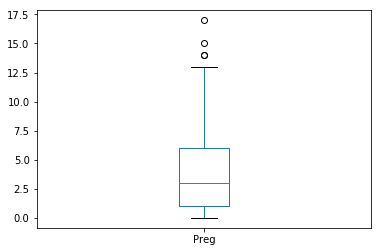

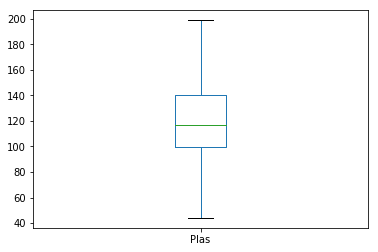

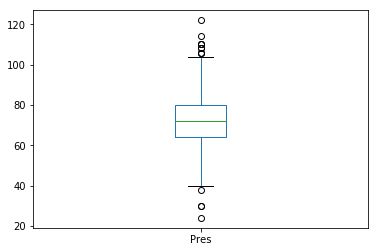

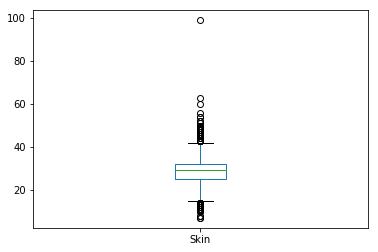

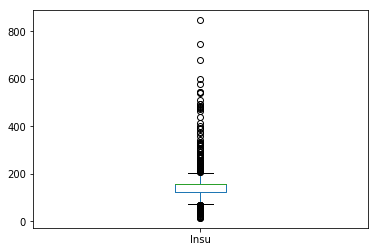

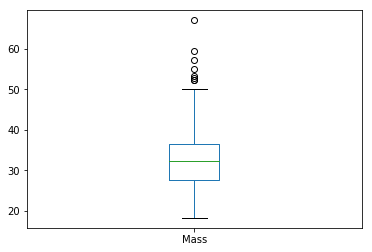

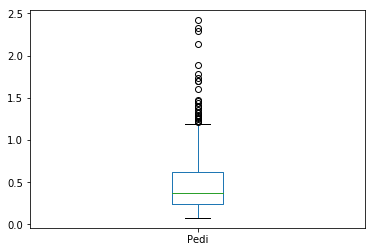

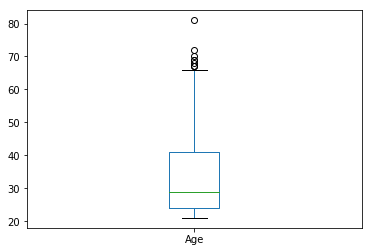

In [359]:
# boxplots are useful for exploring outliers
for col in df.columns[:-1]:    
    df1[col].plot.box()
    plt.show()

##### Almost all columns have outliers

In [360]:
# dealing with outliers with IQR method
#Age, pregrancy are all possible values, so I didn't remove outliers there.
#According to range levels of indicators in real life I applied defferent IQR coefficients
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1

df_clean[['Age', 'Preg']] = df1[['Age', 'Preg']]
df_clean[['Plas', 'Pres', 'Mass']] = df1[['Plas', 'Pres', 'Mass']][~((df1[['Plas', 'Pres', 'Mass']] < (Q1 - 1.5 * IQR)) |(df1[['Plas', 'Pres']] > (Q3 + 1.5 * IQR))).any(axis=1)]           
df_clean[['Skin', 'Insu', 'Pedi']] = df1[['Skin', 'Insu', 'Pedi']][~((df1[['Skin', 'Insu', 'Pedi']] < (Q1 - 2 * IQR)) |(df1[['Skin', 'Insu', 'Pedi']] > (Q3 + 2 * IQR))).any(axis=1)]  
fill_n(df_clean)

,Preg,Plas,Pres,Skin,Insu,Mass,Pedi,Age,Outcome
1,6.0,148.0,72.0,35.0,155.5,33.6,0.6,50.0,1.0
2,1.0,85.0,66.0,29.0,155.5,26.6,0.4,31.0,0.0
3,8.0,183.0,64.0,29.2,155.5,23.3,0.7,32.0,1.0
4,1.0,89.0,66.0,23.0,94.0,28.1,0.2,21.0,0.0
6,5.0,116.0,74.0,29.2,155.5,25.6,0.2,30.0,0.0
...,...,...,...,...,...,...,...,...,...
763,9.0,89.0,62.0,29.2,155.5,22.5,0.1,33.0,0.0
765,2.0,122.0,70.0,27.0,155.5,36.8,0.3,27.0,0.0
766,5.0,121.0,72.0,23.0,112.0,26.2,0.2,30.0,0.0
767,1.0,126.0,60.0,29.2,155.5,30.1,0.3,47.0,1.0


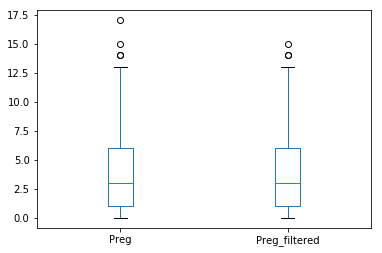

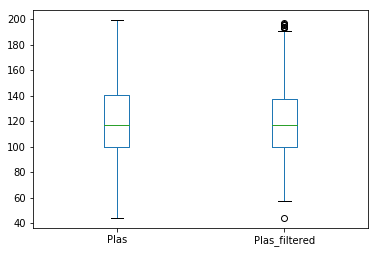

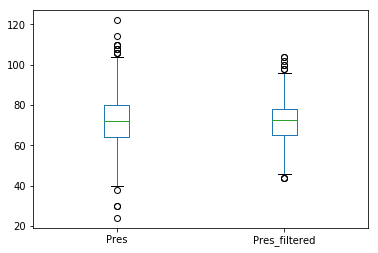

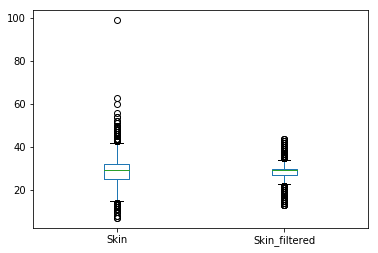

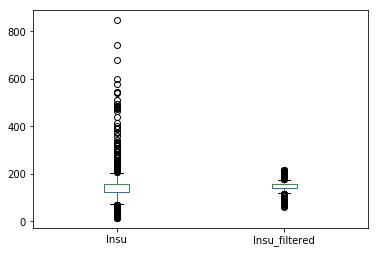

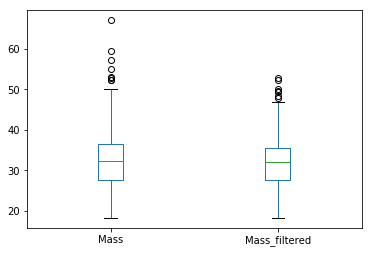

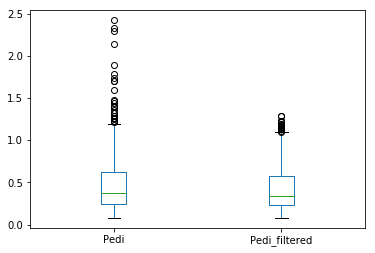

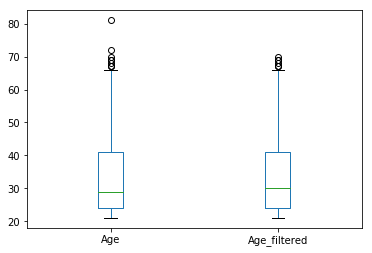

In [361]:
# plot filtered data
for col in df1.columns[:-1]:
    df1[col].to_frame().join(df_clean[col], rsuffix='_filtered').plot.box()
    plt.show()

##### &nbsp;&nbsp;&nbsp;We have binary classification problem with balanced outcome, but we are mostly interested in TP outcome, so I choose True Positive Rate metric (**Recall score**).

In [362]:
# dividing on train and validation samples
scaling(df_clean)
x_train,  x_val, y_train, y_val =  train_test_split(df_clean.iloc[:, :-1], df_clean['Outcome'], test_size = 0.3, random_state = 10)



In [363]:
# K-fold crossvalidation, selected models:
#svm 
#logistic regression 
#gaussian NB
from sklearn.model_selection import KFold
X = x_train.copy()
X.index = [i for i in range(len(X))]
y = y_train.copy()
y.index = [i for i in range(len(X))]
kf = KFold(n_splits=3, shuffle=True)
svm = SVC(gamma='scale')
logr = LogisticRegression(solver='lbfgs')
bayes = GaussianNB()
bayes_scores = []
svm_scores = []
logr_scores = []
for train_index, test_index in kf.split(X):
#    print("TRAIN:", train_index, "TEST:", test_index)
    X_trn, X_tst = X.iloc[train_index, :], X.iloc[test_index, :]
    y_trn, y_tst = y[train_index], y[test_index]
    svm.fit(X_trn, y_trn)
    predict = svm.predict(X_tst)
    svm_scores.append(recall_score(y_tst, predict))
    logr.fit(X_trn, y_trn)
    predict = logr.predict(X_tst)
    logr_scores.append(recall_score(y_tst, predict))
    bayes.fit(X_trn, y_trn)
    predict = bayes.predict(X_tst)
    bayes_scores.append(recall_score(y_tst, predict))
    
print('SVM recall_scores and mean: \n', svm_scores,  np.array(svm_scores).mean(), 
      '\nLogistic Regression recall_scores and mean: \n', logr_scores,  np.array(logr_scores).mean(),
      '\nGaussian NB recall_scores and mean: \n', bayes_scores,  np.array(bayes_scores).mean())

SVM recall_scores and mean: 
 [0.48148148148148145, 0.45652173913043476, 0.5] 0.4793344068706387 
Logistic Regression recall_scores and mean: 
 [0.5, 0.43478260869565216, 0.5185185185185185] 0.48443370907139016 
Gaussian NB recall_scores and mean: 
 [0.6481481481481481, 0.6086956521739131, 0.5925925925925926] 0.6164787976382179


##### So clear best is Gaussian NB

In [364]:
# validate Gaussian NB
bayes.fit(x_train, y_train)
predict = bayes.predict(x_val)
print('Recall score on validation data: \n',recall_score(y_val, predict))


Recall score on validation data: 
 0.6666666666666666
